In [1]:
import sys
sys.path.append('../../')

import numpy as np
import matplotlib.pyplot as plt
import hydra
from tqdm import tqdm

from src.mechanism.single_item import SingleItemAuction
from src.game import Game
from src.strategy import Strategy
from src.learner.soda import SODA
from src.learner.frank_wolfe import FrankWolfe
from src.learner.fictitious_play import FictitiousPlay
from src.learner.poga import POGA

from src.util.setup import create_learner, create_setting
from src.util.metrics import *

In [43]:
# parameter mechanism
bidder = ['1', '1', '1']
o_space = {i:[0,1] for i in bidder}
a_space = {i:[0,1] for i in bidder}

param_prior = {'distribution':'uniform'}
param_util = {'payment_rule': 'first_price', 'tie_breaking': 'lose'}

# parameter approximation game
n = m = 32

# parameter learner
max_iter = int(5e4)
tol = 1e-10
stop_criterion = 'util_loss'
steprule_bool = True
eta = 0.1
beta = 1/20

method = 'poga'

In [44]:
# create mechanism
mechanism = SingleItemAuction(bidder, o_space, a_space, param_prior, param_util)

# create approximation game
game = Game(mechanism, n, m)
game.get_utility(mechanism)

# create learner
if method == 'soda':
    learner = SODA(max_iter, tol, stop_criterion, steprule_bool, eta, beta)
elif method == 'frank_wolfe':
    learner = FrankWolfe(max_iter, tol, stop_criterion)
elif method == 'fictitious_play':
    learner = FictitiousPlay(max_iter, tol, stop_criterion)
elif method == 'poga':
    learner = POGA(max_iter, tol, stop_criterion, steprule_bool, eta, beta)
else:
    print('choose correct learning method')

### Different Init-Methods

In [45]:
bne = get_bne_fpsb(n, odd=True)

In [46]:
strategies = {}
for i in game.set_bidder:
    strategies[i] = Strategy(i, game)
    #strategies[i].initialize('function', {"init_function":  0.25*strategies['1'].o_discr}, lower_bound=1e-10)
    #strategies[i].initialize('matrix', {"init_matrix": bne})
    strategies[i].initialize('random')

#strategies['1'].initialize('function', {"init_function":  0.25 * strategies['1'].o_discr}, lower_bound=1e-20)
#strategies['2'].initialize('function', {"init_function":  0.25 * strategies['2'].o_discr}, lower_bound=1e-20)

# run learner
strategies = learner.run(mechanism, game, strategies, disable_tqdm=False, print=True)

vs = variational_stability(strategies, game, exact_bne=True, normed=False)
vs_bool = not np.any(vs>0)

100%|████████████████████| 50.0k/50.0k [01:15<00:00, 663it/s]


No convergence
Current value of stopping criterion (util_loss) 2e-05
Best value of stopping criterion (util_loss) 0.0


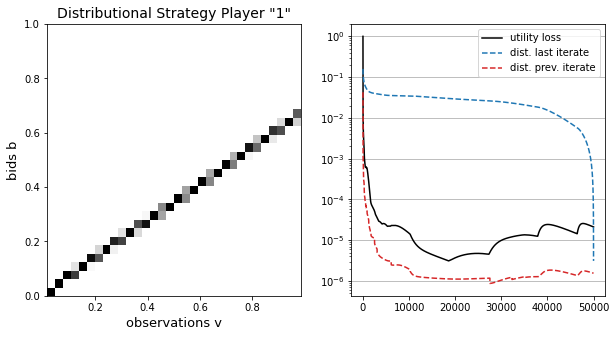

In [47]:
strategies['1'].plot(more=True)

In [48]:
for i in range(n):
    vec = strategies['1'].history_gradient[0][i]
    if sum(vec == vec.max())>1:
        print('found it',i)

In [51]:
strategies['1'].history_gradient[0][14]

array([ 0.00000000e+00,  3.57574914e-04,  1.30859158e-03,  2.96020876e-03,
        4.94918424e-03,  6.45740668e-03,  8.55390600e-03,  1.06287801e-02,
        1.19943723e-02,  1.29661366e-02,  1.28211278e-02,  1.13792414e-02,
        9.06924614e-03,  5.60078978e-03,  2.92027721e-04, -6.69167637e-03,
       -1.54902084e-02, -2.64777856e-02, -3.98090596e-02, -5.61285662e-02,
       -7.41428420e-02, -9.48106162e-02, -1.18672876e-01, -1.45255341e-01,
       -1.74769445e-01, -2.11132773e-01, -2.49708606e-01, -2.91166935e-01,
       -3.38113983e-01, -3.90401096e-01, -4.45480884e-01, -5.06269840e-01])

In [31]:
bool_normed = False
bool_bne = False

vs = variational_stability(strategies, game, exact_bne=bool_bne, normed=bool_normed)
vs_bool = not np.any(vs>0)
brs = best_response_stability(strategies, game, exact_bne=bool_bne, normed=bool_normed)
brs_bool = not np.any(brs>0)
nis = next_iterate_stability(strategies, game, exact_bne=bool_bne, normed=bool_normed)
nis_bool = not np.any(nis>0)
gdir = gradient_direction(strategies, game, normed=True)
gdis = gradient_distance(strategies, game)
gs_bool = not np.any(gdir<0)

wd = wasserstein_dist(strategies, game)

print('Variational Stable'.ljust(40), vs_bool)
print('Best Response Stability satisfied'.ljust(40), brs_bool)
print('Next Iterate Stability satisfied'.ljust(40), nis_bool)

Variational Stable                       True
Best Response Stability satisfied        False
Next Iterate Stability satisfied         False


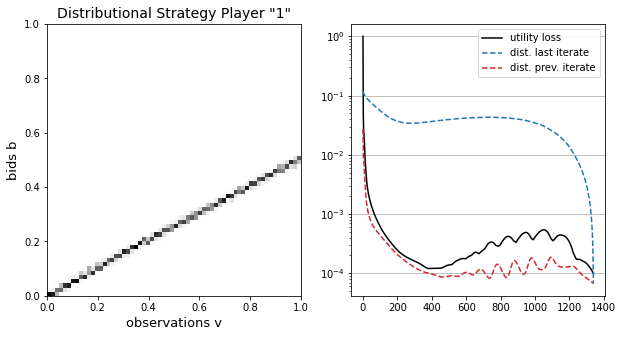

In [74]:
# visualize strategy at iteration "iter"
for i in game.set_bidder:
    strategies[i].plot(more=True, iter=100)

In [75]:
wd[100]

0.016973776471098947

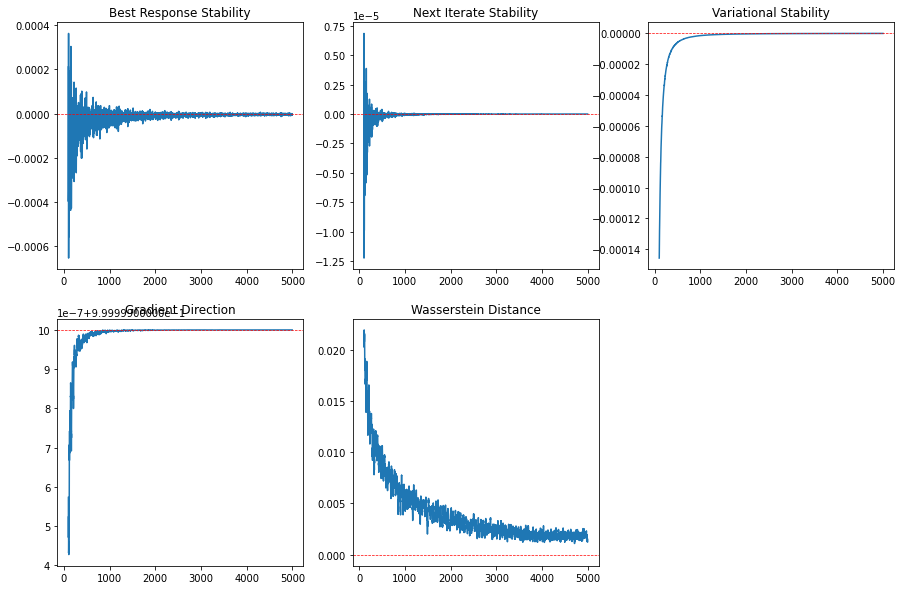

In [33]:
start = 100
num_iter = len(brs)

plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.plot(range(num_iter)[start:],brs[start:])
plt.title('Best Response Stability')
plt.axhline(y=0, color='r', linestyle='--', linewidth=0.7)

plt.subplot(2,3,2)
plt.plot(range(num_iter)[start:],nis[start:])
plt.title('Next Iterate Stability')
plt.axhline(y=0, color='r', linestyle='--', linewidth=0.7)

plt.subplot(2,3,3)
plt.plot(range(num_iter)[start:],vs[start:])
plt.axhline(y=0, color='r', linestyle='--', linewidth=0.7)
plt.title('Variational Stability')

plt.subplot(2,3,4)
plt.plot(range(num_iter)[start:],gdir[start:])
plt.axhline(y=1, color='r', linestyle='--', linewidth=0.7)
plt.title('Gradient Direction')

plt.subplot(2,3,5)
plt.plot(range(num_iter)[start:],wd[start:])
plt.axhline(y=0, color='r', linestyle='--', linewidth=0.7)
#plt.yscale('log')
plt.title('Wasserstein Distance')
plt.show()

It makes sense that VS_normed goes to zero, since the gradient points outwards w.r.t the feasible set.